In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip uninstall catboost -y
    !pip install catboost==1.0.6
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import joblib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from catboost import CatBoost
from catboost import Pool
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 15.5 MB/s 
     |████████████████████████████████| 1.8 MB 95.7 MB/s 
     |████████████████████████████████| 103 kB 74.0 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = True
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
kf = GroupKFold(n_splits=2, seed=CFG.SEED)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, data[CFG.target], data[CFG.target])):
    data.loc[val_idx, "set"] = i
data["set"].value_counts()

In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
# id_match_ids = []
# for id, match_id in zip(train_data['id'], train_data['match_id']):
#     id_match_id = [id, match_id]
#     id_match_id.sort()
#     id_match_ids.append(' '.join(id_match_id))
# train_data['id_match_id'] = id_match_ids
# train_data.head()

In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_catboost(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        train_pool = Pool(X_train, label=y_train)
        valid_pool = Pool(X_valid, label=y_valid)

        if model_dir is None:
            model = CatBoost(params)
            model.fit(train_pool, eval_set=[valid_pool], use_best_model=True, verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        oof = model.predict(X_valid, prediction_type='Probability')
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'catboost_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_catboost(models, feat_df):
    pred = np.array([model.predict(feat_df, prediction_type='Probability') for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'loss_function': 'Logloss',
    'random_state': 42,
    'task_type': 'GPU',
    'num_boost_round' : 100000,
    'early_stopping_rounds' : 20,
    'depth': 14,
    'learning_rate': 0.050251668884450505,
    'random_strength': 89,
    'bagging_temperature': 0.024274706304646895,
}


oof, models = fit_catboost(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
0:	learn: 0.5457136	test: 0.5459677	best: 0.5459677 (0)	total: 88.7ms	remaining: 2h 27m 53s
50:	learn: 0.0471694	test: 0.0478843	best: 0.0478843 (50)	total: 4.63s	remaining: 2h 31m 6s
100:	learn: 0.0442559	test: 0.0450747	best: 0.0450747 (100)	total: 9.21s	remaining: 2h 31m 54s
150:	learn: 0.0429954	test: 0.0439169	best: 0.0439169 (150)	total: 14s	remaining: 2h 33m 48s
200:	learn: 0.0421063	test: 0.0431408	best: 0.0431408 (200)	total: 18.6s	remaining: 2h 34m 12s
250:	learn: 0.0414404	test: 0.0425837	best: 0.0425837 (250)	total: 23.3s	remaining: 2h 34m 36s
300:	learn: 0.0408738	test: 0.0421193	best: 0.0421193 (300)	total: 28s	remaining: 2h 34m 39s
350:	learn: 0.0403118	test: 0.0416693	best: 0.0416693 (350)	total: 32.8s	remaining: 2h 35m 7s
400:	learn: 0.0398558	test: 0.0413198	best: 0.0413198 (400)	total: 37.5s	remaining: 2h 35m 8s
450:	learn: 0.0394254	test: 0.0409919	best: 0.0409919 (450)	total: 42.2s	remaining: 2h 35m 25s
500:	learn: 0.0390453	test: 0.0407177	best: 0.040

In [ ]:
del train_data
gc.collect()

350

#Check Feature Importances

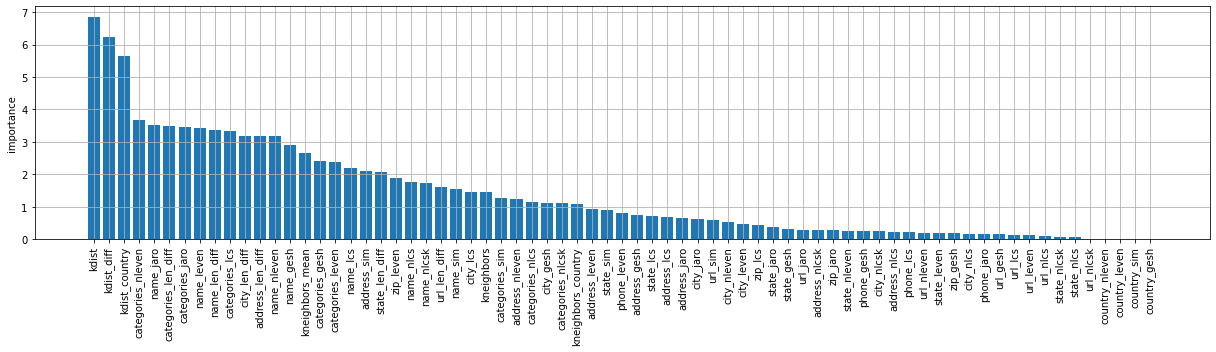

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
models = [joblib.load(os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'catboost_fold{i}.pkl'))) for i in range(CFG.num_split)]

In [ ]:
test_data = add_features(test_data)
# pred = inference_catboost(models, test_data[features])
# test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def inference_catboost(models, feat_df):
    pred = np.array([model.predict(feat_df, prediction_type='Probability') for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
pred = inference_catboost(models, test_data[features])
test_data['pred'] = pred[:, 1]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 14.6 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 209 kB 101.0 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 112 kB 93.3 MB/s 
     |████████████████████████████████| 146 kB 98.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=23d158a2573bbc89df3d3aecda19cb1616f2187f0bc255d40c2417a8f3f5f280
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [ ]:
threshold = study.best_params['threshold']
threshold

0.5621477274681299

In [ ]:
study.best_value

0.8304739465202726

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.830474


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,135426.000000,135426.000000,131022.000000,131022.000000,126199.000000,139247.000000,139247.0,139247.000000,139247.000000,139247.000000,...,139247.000000,139244.000000,139244.000000,139244.000000,139244.000000,139247.000000,139244.000000,139244.000000,139244.000000,1.392470e+05
mean,0.006457,6.263989,0.003519,6.278549,0.425074,6.553617,1.0,0.253183,0.401682,16.742989,...,0.998758,0.998869,0.002284,0.998875,1.997738,0.000022,0.001142,0.998869,0.998869,1.605985e-01
std,0.049150,5.252650,0.023709,5.253467,2.368336,5.312008,0.0,0.304233,0.246763,9.485290,...,0.035226,0.033156,0.066797,0.033189,0.066312,0.004642,0.033398,0.033156,0.033156,1.707043e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.019680e-08
25%,0.000447,2.000000,0.000335,2.000000,0.005857,2.000000,1.0,0.000000,0.203390,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.511920e-02
50%,0.001120,4.000000,0.000862,5.000000,0.056412,5.000000,1.0,0.000000,0.380952,16.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,8.670059e-02
75%,0.003041,10.000000,0.002344,10.000000,0.319828,10.000000,1.0,0.497150,0.576923,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.816465e-01
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.621460e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1656367,E_e883e43e571b9d,E_78735dea917da8,0.002841,2.0,P_e172d32f6efa32,0.002833,2.0,0.002948,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.460660
827692,E_73f74b113ef8f3,E_e885f4f47b652d,0.004903,1.0,P_164444824be17f,0.004896,1.0,0.001357,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.229642
5215124,E_2895813fe400b1,E_500a391f8128ff,0.001755,9.0,P_687ad26fee44e4,0.001691,16.0,0.037417,12.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.051438
13726366,E_7fb803bbbda753,E_7b4db094d2e192,NaN,NaN,P_8c9be8e6945ced,0.004124,17.0,NaN,17.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.001780
6249085,E_f976c18e023d2f,E_2f7362e6641e51,0.000823,10.0,P_cd2215864f9eef,0.000821,10.0,0.003088,10.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000058
2164231,E_ccd2665e30409a,E_306f405b19a36a,0.000626,3.0,P_dd50d3c484c212,0.000617,4.0,0.014201,3.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.068520
2871797,E_0b11a1865239e3,E_f08473394ecf8a,0.000350,5.0,P_9c99371e63efa6,0.000350,5.0,0.000267,5.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.333937
2774894,E_df6b48606a1a10,E_df0f28ec243970,0.000245,4.0,P_b95970476d9f15,0.000245,4.0,0.000343,4.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.025363
1779114,E_1fd043d96f71f2,E_9a91f625cf3d18,0.000260,3.0,P_82afd602117519,0.000195,4.0,0.330420,3.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.001544
2590880,E_8caf32b9cb46a8,E_95aff6567651fb,0.000248,4.0,P_5271fd5f8c141e,0.000248,4.0,0.000026,4.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.092209


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
33114,33114,33114,E_076b2f9a274f1f,AsiaTiqueTheRiverFront@KooKGooD'S Car Space😁😁,13.705073,100.504010,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_1370b800facf55,4,1.0
806089,806089,806089,E_b505df39a164ff,Asiatique,13.705148,100.503114,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_1370b800facf55,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
340150,340150,340150,E_4c75319b85253e,インターナショナルガーデンホテル成田,35.779705,140.323354,241-1,成田市,千葉県,286-0133,JP,NaN,NaN,Hotels,P_52ce89be51d145,4,1.0
621013,621013,621013,E_8ba0762fc556e7,インターナショナルガーデンホテル成田 (International Garden Hotel...,35.782782,140.332881,吉倉241-1,成田市,千葉県,286-0133,JP,http://www.ishinhotels.com,476235522,"Hotels, Resorts",P_52ce89be51d145,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
866378,866378,866378,E_c29dda4355b407,Old Town White Coffee,3.155514,101.694834,Menara Bumiputera-Commerce,Kuala Lumpur,WP Kuala Lumpur,50350,MY,http://www.oldtown.com.my,321949876,"Cafés, Coffee Shops, Asian Restaurants",P_00bfbb3c3f8b25,1,1.0
1029025,1029025,1029025,E_e730fa0d7fc77c,Oldtown White CIMB Jln Raja Laut,3.155590,101.694888,NaN,NaN,NaN,NaN,MY,NaN,NaN,Diners,P_00bfbb3c3f8b25,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
318415,318415,318415,E_478f05ffd6cf37,toko material bangunan swedia ikea jaya,-6.219848,106.663421,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9b73605e5e413e,4,1.0
498008,498008,498008,E_6ff504d1d40cba,IKEA Alam Sutera ~ #oQuarium,-6.219856,106.663180,Sutera Boulevard - Alam Sutera,Pinang,Banten,15144,ID,NaN,NaN,Furniture / Home Stores,P_9b73605e5e413e,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
814822,814822,814822,E_b6fd9634184dc5,Colorado-Utah State Line,39.193122,-109.050797,I-70,Loma,UT,81524,US,NaN,NaN,Border Crossings,P_f074de45a6bda0,4,1.0
1125565,1125565,1125565,E_fd0287319c60c3,Welcome To Colorado,39.190705,-109.013061,NaN,Mack,CO,NaN,US,NaN,NaN,Scenic Lookouts,P_f074de45a6bda0,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
416894,416894,416894,E_5da95bcdfd3179,LA UVA,18.003125,-92.941079,NaN,NaN,NaN,NaN,MX,NaN,NaN,Breweries,P_7bec481d00b267,3,1.0
974932,974932,974932,E_db0141aeff9ae9,MicheRock,18.002597,-92.933733,NaN,NaN,NaN,NaN,MX,NaN,NaN,Beer Stores,P_7bec481d00b267,3,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
162342,162342,162342,E_2465559af0d4a0,McDonald's Juanda,-6.600349,106.792164,NaN,NaN,NaN,NaN,ID,NaN,NaN,Fast Food Restaurants,P_8b2031a969e4e1,4,1.0
207848,207848,207848,E_2ea4a5b9a0a20e,Mc D Jl djuanda,-6.601002,106.794906,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_8b2031a969e4e1,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
155901,155901,155901,E_22ec6b9711b636,Mohammed Bin Zayed Al-Jazira Club Stadium,24.452085,54.388020,Al Muroor Rd,Abu Dhabi,UAE,NaN,AE,NaN,NaN,Football Stadiums,P_4c154054f6458d,1,1.0
1084533,1084533,1084533,E_f3b56dc46f8310,Al Jazira Club,24.452587,54.392303,"24.452827, 54.392170",Abu Dhabi,UAE,NaN,AE,NaN,NaN,"Soccer Stadiums, Soccer Fields",P_4c154054f6458d,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
84517,84517,84517,E_12ed96dd109848,Room 14 320,25.129896,55.116669,Atlantis The Palm,Dubai,NaN,NaN,AE,NaN,NaN,Hotels,P_827ac12616a89d,4,1.0
184460,184460,184460,E_296224dadb5569,Atlantis The Palm أتلانتس النخلة,25.130593,55.116707,NaN,NaN,NaN,NaN,AE,NaN,NaN,Beaches,P_827ac12616a89d,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
237462,237462,237462,E_354ff91c92ae36,Yonemoto Coffee,35.666070,139.771041,NaN,NaN,NaN,NaN,JP,NaN,NaN,Coffee Shops,P_089b998838d922,1,1.0
253682,253682,253682,E_38f94a55cd58a4,米本珈琲 本店,35.665615,139.771101,築地4-11-1,中央区,東京都,104-0045,JP,http://yonemoto-coffee.com,335416473,"Coffee Shops, Cafés",P_089b998838d922,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
172629,172629,172629,E_26b8ee111c3826,St Francis Xavier Primary School,-37.819202,145.130990,NaN,box hill,VIC,3128,AU,NaN,NaN,Elementary Schools,P_16f06fcf119f6b,1,1.0
454898,454898,454898,E_663a8a9f5ce9e7,st francis xavier ps,-37.818397,145.132437,NaN,box hill,VIC,NaN,AU,NaN,NaN,College Academic Buildings,P_16f06fcf119f6b,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
687686,687686,687686,E_9a734a4bbe2253,KFC Buaran,-6.222248,106.923442,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9aba621ef36f9a,3,1.0
1123149,1123149,1123149,E_fc7aa05f1472fc,Kfc duren sawit,-6.222362,106.923453,Jl. Raden Inten RT. 09 RW. 10,Jakarta,NaN,NaN,ID,NaN,NaN,American Restaurants,P_9aba621ef36f9a,3,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
180519,180519,180519,E_287e80d646276e,dokter els wouters,51.169089,4.136360,Nijverheidsstraat,NaN,NaN,NaN,BE,NaN,NaN,Doctor's Offices,P_306070f20b011d,1,1.0
836492,836492,836492,E_bbd836932265c7,Dokter Wauters,51.169181,4.134958,Nijverheidsstraat,Sint-Niklaas,NaN,9100,BE,NaN,NaN,Doctor's Offices,P_306070f20b011d,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
337123,337123,337123,E_4bc49f803fcafb,Villa Istana Bunga blok D5,-6.800851,107.582154,"Jln. Kolonel Masturi km 6,3 Villa Istana Bunga",Bandung,West Java,40559,ID,NaN,NaN,Wine Bars,P_9d875fc5e91d21,4,1.0
1033912,1033912,1033912,E_e84f7390dfb636,Vila Taman Bunga,-6.798607,107.582384,Lembang,Bandung,Jawa Barat,NaN,ID,NaN,NaN,NaN,P_9d875fc5e91d21,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
861957,861957,861957,E_c19bf97b71649e,Osman Zeki Oral Sergi Salonu,41.282741,31.415491,NaN,Ereğli,Zonguldak,NaN,TR,NaN,NaN,Art Galleries,P_2117cac1bbf7da,3,1.0
1032157,1032157,1032157,E_e7ea88afa66205,AKAM,41.282604,31.416033,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Nightlife,P_2117cac1bbf7da,3,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
253969,253969,253969,E_3909fcd113e361,Kuşadası - Güzelcamlı Plajı,37.725656,27.243341,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_8aaa29401f8749,4,1.0
737405,737405,737405,E_a5a7da4d65f78a,Güzelçamlı Sahili,37.726095,27.238874,Güzelçamlı,Kusadasi,Türkiye,NaN,TR,NaN,NaN,Beaches,P_8aaa29401f8749,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
106166,106166,106166,E_17caba3eaa0221,Little Saints: pre-k room,41.670117,-85.716578,NaN,Middlebury,IN,46540,US,NaN,NaN,NaN,P_83888142468785,1,1.0
306702,306702,306702,E_44e0825058f087,Little Saints: Infant Room,41.669919,-85.715929,NaN,Middlebury,NaN,46540,US,NaN,NaN,NaN,P_83888142468785,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
809623,809623,809623,E_b5d29f91259246,Озеро,57.202430,33.083877,NaN,NaN,NaN,NaN,RU,NaN,NaN,Pools,P_b59a6209542305,4,1.0
1032367,1032367,1032367,E_e7f5b923c10bc4,#Селигер2013,57.246742,33.078683,Осташковский район,Селигер,Тверская область,NaN,RU,NaN,NaN,Other Great Outdoors,P_b59a6209542305,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
144173,144173,144173,E_205083d3a2688d,Обитель Зла,55.775679,37.554182,NaN,NaN,NaN,NaN,RU,NaN,NaN,General Colleges & Universities,P_410c5accf362ba,4,1.0
801454,801454,801454,E_b3fc70d6fdcb15,БЦ Нордстар 20й этаж,55.775514,37.553421,NaN,NaN,NaN,NaN,RU,NaN,NaN,"Coworking Spaces, Offices, Buildings",P_410c5accf362ba,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
821317,821317,821317,E_b87103901d5173,Зал Ожидания,54.515032,36.273070,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_b3311fbc6c1101,4,1.0
1020223,1020223,1020223,E_e535cb39e96013,Элитный коридор Элитной Гимназии🏪,54.515832,36.272914,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_b3311fbc6c1101,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
102125,102125,102125,E_16e1ff80519937,เจริญกรุงasintique,13.705173,100.502532,NaN,NaN,NaN,NaN,TH,NaN,NaN,Storage Facilities,P_1370b800facf55,4,1.0
889566,889566,889566,E_c7d34fe6386210,Asiatique The Riverfront (เอเชียทีค เดอะ ริเวอ...,13.704008,100.503630,2194 Charoen Krung Rd,Bang Kho Laem,Bangkok,10120,TH,http://www.asiatiquethailand.com,21084488,Shopping Plazas,P_1370b800facf55,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
259429,259429,259429,E_3a4010c330f457,Jacksonville Veterans Memorial Arena,30.326498,-81.645428,NaN,Jacksonville,FL,NaN,US,NaN,NaN,Music Venues,P_4df5d46f7c160b,4,1.0
931735,931735,931735,E_d14dcc581beb0e,VyStar Veterans Memorial Arena,30.325794,-81.644581,300 A Philip Randolph Blvd,Jacksonville,FL,32202,US,http://www.jaxevents.com/,9046303900,"General Entertainment, Athletics & Sports",P_4df5d46f7c160b,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
235971,235971,235971,E_34f8bfe3cae282,WBH Spitze 5. Stock,52.500065,13.385791,NaN,NaN,NaN,NaN,DE,NaN,NaN,Offices,P_89b86480e516b8,2,1.0
759084,759084,759084,E_aa86da9eb796c0,Willy-Brandt-Haus,52.500158,13.388699,Wilhelmstr. 140,Berlin,Berlin,10963,DE,https://www.willy-brandt-haus.de,3025991500,"Campaign Offices, Event Spaces",P_89b86480e516b8,2,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
537972,537972,537972,E_78e594d12d6301,У Дэнчика На Алтайской,59.848526,30.326343,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_18d90a5408a4bf,4,1.0
872798,872798,872798,E_c40b850d701b6e,У Зои на химии,59.848967,30.325508,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_18d90a5408a4bf,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
453531,453531,453531,E_65eb77eaeb89f9,Hospital Angeles Pedregal,19.311628,-99.220885,Camino a Santa Teresa 1055,Heroes de Padierna,DF,10700,MX,NaN,NaN,Hospitals,P_077cab0f706897,4,1.0
522888,522888,522888,E_7581a04377586a,Habitación 403,19.311495,-99.220978,NaN,NaN,NaN,NaN,MX,NaN,NaN,Hospitals,P_077cab0f706897,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
812286,812286,812286,E_b66af4c36cd74f,La Madelaine (Av. Cordoba),-34.599015,-58.381543,NaN,NaN,NaN,NaN,AR,NaN,NaN,Cafés,P_bfe5eebfbd1560,1,1.0
947714,947714,947714,E_d4dfe817192540,La Madeleine,-34.599152,-58.381058,Avenida Córdoba 1000,Buenos Aires,Argentina,NaN,AR,NaN,01143227139,"Coffee Shops, Gastropubs",P_bfe5eebfbd1560,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
347930,347930,347930,E_4e309304af78bc,SPBU 24-35354 Pringsewu,-5.240983,104.967315,NaN,Pringsewu,NaN,NaN,ID,NaN,NaN,Gas Stations,P_2d4c7c8c1de90d,2,1.0
821034,821034,821034,E_b85e65eaac023d,SPBU Pertamina,-5.357004,104.953455,"Jl. Jend. Sudirman, Pringsewu Barat",Pringsewu,Lampung,35373,ID,NaN,NaN,Gas Stations,P_2d4c7c8c1de90d,2,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
755047,755047,755047,E_a99cf8669e9d0f,Школа 4 Кабинет Печкина,59.929848,30.241537,Опочинина 10,Санкт-Петербург,NaN,NaN,RU,NaN,NaN,Schools,P_d39b1777ac58b7,4,1.0
821211,821211,821211,E_b86a721e0a4030,3-ий Этаж школы кусто,59.932193,30.237890,NaN,NaN,NaN,NaN,RU,NaN,NaN,Buildings,P_d39b1777ac58b7,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
338564,338564,338564,E_4c1b86129c7ef9,Section 228A MetLife Stadium,40.812701,-74.074254,NaN,East Rutherford,NJ,NaN,US,NaN,NaN,Football Stadiums,P_0c62231a214463,4,1.0
575771,575771,575771,E_816c6b8ea5bc8b,Metlife Stadium,40.813872,-74.072382,1 Metlife Stadium Dr,East Rutherford,NJ,07073,US,NaN,NaN,Athletics & Sports,P_0c62231a214463,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
113644,113644,113644,E_1978781af33ba7,ธนาคารกรุงเทพ สาขาย่อยพันธุ์ทิพพลาซ่า,18.782041,99.001473,Pantip Plaza,เชียงใหท่,Thailand,NaN,TH,NaN,NaN,Banks,P_beca2a88b63a94,1,1.0
758342,758342,758342,E_aa5c60a752eb19,ธนาคารกรุงเทพ (Bangkok Bank),18.781211,98.999504,Pantip Plaza,Mueang Chiang Mai,Chiang Mai,50100,TH,NaN,NaN,Banks,P_beca2a88b63a94,1,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,58197.000000,58197.000000,56445.000000,56445.000000,54782.000000,59413.000000,59413.0,59413.000000,59413.000000,59413.000000,...,59413.000000,59412.000000,59412.000000,59412.000000,59412.00000,59413.0,59412.000000,59412.000000,59412.000000,59413.000000
mean,0.008652,4.706583,0.003729,4.692355,0.407384,4.965067,0.0,0.584629,0.608548,11.994681,...,0.998098,0.998300,0.003602,0.998205,1.99660,0.0,0.001801,0.998300,0.998300,0.814695
std,0.113074,4.869430,0.018465,4.855664,1.659863,4.996463,0.0,0.350118,0.245069,9.060462,...,0.043570,0.040475,0.084602,0.042246,0.08095,0.0,0.042301,0.040475,0.040475,0.138640
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.562157
25%,0.000304,1.000000,0.000233,1.000000,0.007973,1.000000,0.0,0.346920,0.444444,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.00000,0.0,0.000000,1.000000,1.000000,0.690841
50%,0.000882,2.000000,0.000661,2.000000,0.068360,3.000000,0.0,0.651793,0.625000,11.000000,...,1.000000,1.000000,0.000000,1.000000,2.00000,0.0,0.000000,1.000000,1.000000,0.830720
75%,0.003046,7.000000,0.002252,7.000000,0.315503,7.500000,0.0,0.882934,0.793103,17.000000,...,1.000000,1.000000,0.000000,1.000000,2.00000,0.0,0.000000,1.000000,1.000000,0.947828
max,11.519732,19.000000,1.385816,19.000000,94.717490,19.000000,0.0,1.000000,1.000000,57.000000,...,1.000000,1.000000,2.000000,1.000000,2.00000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
8272999,E_873bc5eefe34e4,E_50750edf2e8f3e,0.000912,14.0,P_18d2a50d85deee,0.000857,14.0,0.063271,14.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.626979
647190,E_22de682fe2657c,E_c1b0b72057f739,0.011734,1.0,P_196d2042442f75,0.011597,1.0,0.011797,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.993195
5018185,E_cfe7539ef770e4,E_6b520fc000fd9c,0.000676,8.0,P_985254befdd221,0.000450,6.0,0.502277,7.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.929341
2400496,E_370d86fe8dc387,E_0144c39d150e02,0.000129,4.0,P_a7af1ab0413397,0.000129,4.0,0.000014,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.644549
1623553,E_d9bcd01c6006fd,E_a1e3203526450b,0.000267,2.0,P_6197faaef23eae,0.000265,5.0,0.009537,3.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.710474
800975,E_67e1176bc9d390,E_01a0b320a9d90f,0.000248,1.0,P_4302bb26088d13,0.000248,1.0,0.000116,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.881171
10881809,E_1c45613c9ecf65,E_ae7fb369838058,0.038627,19.0,NaN,NaN,NaN,NaN,19.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.673246
4330038,E_9a74279c94ff2f,E_920b3ac0d2f3e7,0.011662,7.0,P_ae024275914388,0.011604,7.0,0.004943,7.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.794764
6203519,E_e4dba5eb8812e1,E_2faa5726e701e9,0.087357,10.0,NaN,NaN,NaN,NaN,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.986382
765521,E_5804ff9300740a,E_d07bdc83cb85aa,0.009393,1.0,P_849ba66de33ca2,0.009368,1.0,0.002595,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.966344


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2296,2296,2296,E_008adc9c8f8842,УРФ Сбербанка,55.699224,37.577311,NaN,NaN,NaN,NaN,RU,NaN,NaN,Banks,P_bd23bfeadcd9cc,0,1.0
436291,436291,436291,E_620d4620d08c83,Сбербанк,55.702837,37.572851,"Ленинский просп., 45",Moscow,Moscow,NaN,RU,http://www.sberbank.ru,NaN,Banks,P_e45587ee084d69,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
439016,439016,439016,E_62aaa0fd2ede14,Ankara Asliye Ceza Mahkemeleri,39.930390,32.853286,NaN,Ankara,NaN,NaN,TR,NaN,NaN,Courthouses,P_f58871cd625807,4,1.0
935644,935644,935644,E_d22cb3aafc12ae,3.Asliye Ceza Mahkemesi,39.930153,32.853325,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_e00b9832620943,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
276072,276072,276072,E_3df8d73d9d7f1d,Vela Bar,38.664754,-9.076831,NaN,Barreiro,NaN,NaN,PT,NaN,NaN,Bars,P_dc7f3873e5f27a,0,1.0
483153,483153,483153,E_6c95eb83722e85,Clube de Vela do Barreiro,38.665257,-9.076316,Av. Bento Gonçalves,Barreiro,NaN,2830-304,PT,NaN,NaN,Bars,P_09e750ace53c09,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
654113,654113,654113,E_92ff409a691cd0,a.v.v noble イオンモール大和郡山店,34.649906,135.802603,下三橋町741,大和郡山市,奈良県,NaN,JP,NaN,NaN,Boutiques,P_4980c4d4e030ca,0,1.0
1053413,1053413,1053413,E_ecb291e7246cab,イオン 大和郡山店,34.651703,135.802204,下三橋町741,大和郡山市,奈良県,639-1101,JP,http://www.aeonretail.jp,743547111,Supermarkets,P_8179b94db97c90,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
719889,719889,719889,E_a1b825548695dd,5.01 (1 Ruskin Square),51.376060,-0.093446,1 Ruskin Square,Croydon,England,CR0 2WF,GB,NaN,NaN,Meeting Rooms,P_d9982985058f7b,0,1.0
832874,832874,832874,E_bb0884c7a32719,1 Ruskin Square,51.376142,-0.093577,Ruskin Square,Croydon,Surrey,CR0 2WF,GB,NaN,NaN,"Buildings, Meeting Rooms",P_58cc622032d304,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231544,231544,231544,E_33f8fa534666e7,Planet Fitness,41.932111,-71.354159,NaN,North Attleborough,MA,02760,US,NaN,NaN,Gyms or Fitness Centers,P_2a44f99c7bdc7c,0,1.0
1081002,1081002,1081002,E_f2ea11fc6d52f6,Planet Fitness,41.931856,-71.354035,40 Cumberland Ave,North Attleboro,MA,02760,US,NaN,(508) 639-5382,Gyms,P_8935e62ac3ffe3,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
411321,411321,411321,E_5c6f477747113c,Traveler's Coffee,56.011437,92.860212,"Проспект Мира, 65",NaN,NaN,NaN,RU,NaN,NaN,Coffee Shops,P_7e61bb6698071f,1,1.0
688178,688178,688178,E_9a9059480dbe20,Coffee Bulka,56.011748,92.865336,Проспект мира 86,Красноярск,Красноярский край,NaN,RU,NaN,NaN,"Cafés, Coffee Shops",P_3c281a217edbfd,2,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
510468,510468,510468,E_72c0cb63bf91b7,BreadTalk,6.891591,79.855423,Haig Road,Colombo,NaN,NaN,LK,NaN,NaN,Bakeries,P_353c57ab9b999d,1,1.0
996449,996449,996449,E_dfda0518ae8c39,Bread Talk,6.892813,79.864593,NaN,NaN,NaN,NaN,LK,NaN,NaN,Bakeries,P_7ce4d6c1c57542,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
557048,557048,557048,E_7d30ba4a6ecbfc,FAP- D407,-1.440355,-48.492083,NaN,Belém,PA,NaN,BR,NaN,NaN,Law Schools,P_7f26def0ab3982,0,1.0
954679,954679,954679,E_d67968ee6026f8,Sala E-202 FAP,-1.440490,-48.491947,NaN,NaN,NaN,NaN,BR,NaN,NaN,Law Schools,P_a3fca8c27ebb3a,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
390386,390386,390386,E_57b19afe70cd23,Auchan Drive,48.713389,2.438512,NaN,NaN,NaN,NaN,FR,NaN,NaN,Supermarkets,P_1bf1bdd94bd201,0,1.0
705351,705351,705351,E_9e6cc15578043e,Auchan Drive Montgeron,48.713062,2.438308,Rue Mercure,Montgeron,NaN,91230,FR,https://www.auchan.fr/magasins/drive/montgeron...,+33177571100,Grocery Stores,P_239d96aa99e9cf,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
882544,882544,882544,E_c639b3a2e60ae1,INTI International College Penang,5.34160,100.281835,1-Z Lebuh Bukit Jambul,Bukit Jambul,Penang,11900,MY,http://www.newinti.edu.my/main/about-campuses-...,46310138,General Colleges & Universities,P_6c4821674230ed,0,1.0
1011170,1011170,1011170,E_e325e1cfc66b47,INTI,5.34154,100.281662,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Classrooms,P_93ee0a1fa56e0a,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1082162,1082162,1082162,E_f32bd846a67b95,Ward 5A-5H,3.148786,101.721689,Prince Court Medical Centre,Kuala Lumpur City Centre,Kuala Lumpur,50450,MY,NaN,+60321600000,Hospital Wards,P_1a616fbf4abe89,4,1.0
1123371,1123371,1123371,E_fc85ea86118fd0,4G Ward,3.147637,101.721461,Prince Court Medical Centre,Jalan Kia Peng,Kuala Lumpur,50450,MY,NaN,+60321600000,Hospital Wards,P_80fd7e6c508cbd,2,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
60168,60168,60168,E_0d764e24af73fa,Singapore General hospital Blk 4 Ward 43,1.279908,103.835982,NaN,NaN,NaN,NaN,SG,NaN,NaN,Hospitals,P_893bd804f16727,0,1.0
913794,913794,913794,E_cd47046293d389,Singapore General Hospital Ward 46 tea room,1.279677,103.834966,NaN,NaN,NaN,NaN,SG,NaN,NaN,Hospitals,P_b8ad2bf60f3317,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
435708,435708,435708,E_61ec694d30c920,Kaj Kodovski,41.719385,21.769894,NaN,NaN,NaN,NaN,MK,NaN,NaN,College Classrooms,P_ba11ffffbd66ed,0,1.0
903847,903847,903847,E_cb098135f44567,Kaj Batkoto👑,41.858900,21.932213,NaN,NaN,NaN,NaN,MK,NaN,NaN,Castles,P_cb79a40dc88f37,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
618173,618173,618173,E_8b0019f36be541,Kroger Corporate Brands Office,39.106591,-84.513848,1014 Vine St,Cincinnati,OH,45202,US,NaN,NaN,Offices,P_11434ed95215f3,1,1.0
671093,671093,671093,E_96bf4027f83ea7,Evan's Office at Kroger,39.107664,-84.521459,1014 Vine Street,NaN,NaN,45202,US,NaN,NaN,Offices,P_d6c6c11a890de7,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
562123,562123,562123,E_7e53e32507f5ec,LaundroMax,42.475592,-71.149631,NaN,Woburn,MA,01801,US,NaN,NaN,Laundry Services,P_23462fb5a1e4cc,0,1.0
608123,608123,608123,E_88b0c3243ae85a,The Laundry,42.475513,-71.149909,233 Main St,Woburn,MA,01801,US,NaN,NaN,Laundry Services,P_ec5a75155daa3d,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
581642,581642,581642,E_82becd5da51298,Цветы,55.679512,37.737904,NaN,Москва,NaN,109387,RU,NaN,NaN,Flower Shops,P_e9add64cbab830,0,1.0
1109299,1109299,1109299,E_f9570e120218ed,Цветы,55.683942,37.750750,NaN,NaN,NaN,NaN,RU,NaN,NaN,Flower Shops,P_df8eb6eb21e070,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
452871,452871,452871,E_65c28225fe1412,T1645 Singapore Polytechnic,1.310349,103.777821,Singapore Polytechnic,Singapore,Singapore,NaN,SG,NaN,NaN,"College Classrooms, College Academic Buildings",P_78aef24d2384c2,0,1.0
1112325,1112325,1112325,E_fa0ac316badf31,Singapore Polytechnic T16,1.310570,103.777914,NaN,NaN,NaN,NaN,SG,NaN,NaN,College Engineering Buildings,P_e28c7c86968c23,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
8002,8002,8002,E_01d0c6140703a8,CONFHIC - Sala Grupo 1,38.717623,-9.253774,NaN,Lisbona,NaN,NaN,PT,NaN,NaN,Steakhouses,P_8b6eaec64635e7,0,1.0
184874,184874,184874,E_2979263772fb11,CONFHIC - Sala Grupo 6,38.717625,-9.253877,NaN,Lisbona,NaN,NaN,PT,NaN,NaN,Theaters,P_a8f649a75380b4,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
919714,919714,919714,E_ce93f3eb775f12,Авилон BMW,55.714686,37.716279,"Волгоградский просп., 41, стр. 1",Москва,Москва,109316,RU,http://bmw-avilon.ru,4957304445,"Auto Dealerships, Automotive Shops",P_6054369584fb6b,0,1.0
997153,997153,997153,E_e001ee94e239ca,Долина Авилон,55.713214,37.720941,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auto Dealerships,P_402e34685ef875,2,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1049069,1049069,1049069,E_ebb89c0b9a28a1,ПСПбГМУ им. акад. И. П. Павлова,59.966227,30.318827,"ул. Льва Толстого, 6-8",Санкт-Петербург,Санкт-Петербург,197022,RU,http://www.spb-gmu.ru,8122349569,"Medical Schools, Medical Labs, Hospitals",P_a1e78fd58afe8f,1,1.0
1069505,1069505,1069505,E_f05f0953ff770c,Поликлинический корпус ПСПБГМУ им. акад. И. П....,59.966076,30.317871,"ул. Льва Толстого, 6/8",Санкт-Петербург,Санкт-Петербург,NaN,RU,NaN,NaN,"Medical Centers, Medical Schools, College Acad...",P_76087442928dfe,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
357031,357031,357031,E_504083fda83895,الاستراحة,24.843205,46.802749,NaN,NaN,NaN,NaN,SA,NaN,NaN,Hookah Bars,P_f68416d11610a6,0,1.0
1136215,1136215,1136215,E_ff69854e33c1f2,Estra7at els3ada..,24.850532,46.808846,NaN,NaN,NaN,NaN,SA,NaN,NaN,Hookah Bars,P_1e0303f2544487,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
263149,263149,263149,E_3b1789f5ab43c6,Mersa Otomotiv,36.924053,30.643692,NaN,NaN,NaN,NaN,TR,NaN,NaN,Automotive Shops,P_98dcc4b6bc5653,0,1.0
503405,503405,503405,E_7131af3c751132,Arzuman Otomotiv,36.919887,30.642676,Yeni Sanayi,NaN,NaN,NaN,TR,NaN,NaN,Automotive Shops,P_238f2871c8a8a1,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64119,64119,64119,E_0e5a2c4f9fe1e5,Migros Jet,39.753613,30.494259,Büyükdere Mah. Millet Cad.,Eskişehir,Eskisehir,NaN,TR,http://www.migros.com.tr,NaN,Grocery Stores,P_2844d86ecfbeff,0,1.0
517691,517691,517691,E_745c594a75af83,Migros,39.757321,30.499619,Büyükdere Mah. Sevdik Sok. No:1/A,Eski̇şehi̇r,NaN,NaN,TR,http://www.migros.com.tr,8503102426,Grocery Stores,P_f23b0bd6afe26f,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
849538,849538,849538,E_bec920830f9317,C's Bar Grand Hyatt,-6.194123,106.822759,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_dcc427464bcf78,2,1.0
1004827,1004827,1004827,E_e1b805649558ce,Grand Café,-6.193984,106.822623,"Grand Hyatt Jakarta, Lobby Level",Jakarta Pusat,DKI Jakarta,10350,ID,http://www.jakarta.grand.hyatt.com,2129921234,"Breakfast Spots, Cafés",P_a524b73e4a81f5,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
597182,597182,597182,E_8637e2828105c3,AZ Oudenaarde - Dermatologie,50.84349,3.601755,NaN,Oudenaarde,NaN,9700,BE,NaN,NaN,Hospitals,P_66d3a0f1f435be,0,1.0
793099,793099,793099,E_b221db52f90fd4,Audiologie Az Oudenaarde,50.84366,3.601519,NaN,NaN,NaN,NaN,BE,NaN,NaN,Hospitals,P_af838bb4216ab7,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
256246,256246,256246,E_398bf401b092e3,Bloed Street Mall,-25.740020,28.192302,Cnr. Bloed St. & Van der walt st. Pretoria Cen...,Pretoria,Gauteng,0001,ZA,NaN,123231261,Shopping Malls,P_f744d3e2d112f1,0,1.0
328866,328866,328866,E_49ed0ed531c2d8,Spar Bloed Mall,-25.740406,28.189542,Cnr Bloed Street & Van Der Walt Street,Pretoria,NaN,NaN,ZA,NaN,NaN,Department Stores,P_7ed867d836463e,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
650032,650032,650032,E_92109109e414b2,Parány Pékség,46.039551,17.992237,NaN,NaN,NaN,NaN,HU,NaN,NaN,Bakeries,P_7c562660b9cbf7,0,1.0
939598,939598,939598,E_d30a0e833d4968,Grappa Pékség,46.064745,18.198874,Ybl Miklós u. 7.,Pécs,Baranya,7633,HU,NaN,NaN,Bakeries,P_3ced0cea2941d7,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
701816,701816,701816,E_9da025f2b6831a,кафедра хирургии,47.229667,39.741004,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_7e9ac07989be98,4,1.0
1004085,1004085,1004085,E_e18e1e37b9ab1a,кафедра топографической анатомии и оперативной...,47.229499,39.739016,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_18cca344d0d741,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
452899,452899,452899,E_65c43a27a5fe39,ธนาคารทหารไทย (TMB Bank),20.434283,99.880999,Mae Sai,Mae Sai,Chiang Rai,57130,TH,NaN,NaN,Banks,P_2d520d147047e1,0,1.0
495247,495247,495247,E_6f50ba78656ec2,ธนาคารไทยพาณิชย์ สาขาแม่สาย,20.435302,99.884385,NaN,NaN,NaN,NaN,TH,NaN,NaN,Banks,P_81bc4c791a604e,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,863541.000000,863541.000000,855550.000000,855550.000000,277823.000000,866233.000000,866233.0,866233.000000,866232.000000,866232.000000,...,866233.000000,866224.000000,866224.000000,866224.000000,866224.000000,866233.000000,866224.000000,866224.000000,866224.000000,866233.000000
mean,0.001812,1.076352,0.000792,1.074457,0.425739,1.145515,1.0,0.815622,0.908910,2.794964,...,0.999500,0.999605,0.000824,0.999590,1.999209,0.000001,0.000412,0.999605,0.999605,0.978007
std,0.028688,2.737388,0.005868,2.756950,1.954242,2.858580,0.0,0.349498,0.198023,6.505835,...,0.022352,0.019595,0.040451,0.020186,0.039191,0.001074,0.020226,0.019595,0.019595,0.068773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562159
25%,0.000000,0.000000,0.000000,0.000000,0.007942,0.000000,1.0,0.818127,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.998809
50%,0.000000,0.000000,0.000000,0.000000,0.068863,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.999998
75%,0.000224,1.000000,0.000162,1.000000,0.337466,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,1.099809,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
561129,E_fc3f46df77f807,E_fc3f46df77f807,0.000000,0.0,P_8cde35ad12e105,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999997
575886,E_02ec46886909cd,E_872c003333a91d,0.000123,1.0,P_8d955431e85df1,0.000072,1.0,0.710755,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999464
1007948,E_c4ed0bd07cd74b,E_11200573890366,0.000123,1.0,P_103bea85b0dcc0,0.000119,1.0,0.028855,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.988116
51048,E_16e2d6285a7198,E_16e2d6285a7198,0.000000,0.0,P_21a905344dac21,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
354823,E_9f3c726549bfc1,E_9f3c726549bfc1,0.000000,0.0,P_541538d6348fa6,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999999
1054552,E_d9e8e3ae5ed8eb,E_61452200ef82c5,0.000445,1.0,P_24687ec9079079,0.000425,1.0,0.046376,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.970427
521650,E_ea5d46d75ae140,E_ea5d46d75ae140,0.000000,0.0,P_dc78b44d075730,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
807785,E_6b02215d490496,E_582aa238ad5dbd,0.000093,1.0,P_6d31f9882f4d79,0.000093,1.0,0.000941,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.835135
179201,E_5075d524ceee77,E_5075d524ceee77,0.000000,0.0,P_a21766f3f0bf47,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
246557,E_6ebb58d6694627,E_6ebb58d6694627,0.000000,0.0,P_c1939ee299ecb0,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
726952,726952,726952,E_a3498c35f7a542,Panorama Tour & Travel,-8.713337,115.223482,Jalan By Pass Ngurah Rai No. 620,Denpasar,Bali,NaN,ID,NaN,NaN,"Offices, Buildings, General Travel",P_46099a93ee0456,1,1.0
943775,943775,943775,E_d3ffa11d32f443,Panorama tour and travel,-8.713364,115.223776,Bypass Sanur,Denpasar,Bali,NaN,ID,NaN,NaN,General Travel,P_46099a93ee0456,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
236800,236800,236800,E_352946119dc855,U.S. Post Office,36.317849,-95.61044,400 W 9th St,Claremore,OK,74017,US,https://tools.usps.com/find-location.htm?locat...,+18002758777,Post Offices,P_7e1a756eb4d084,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
867117,867117,867117,E_c2c702451b89ca,Chevron,32.84552,-86.624876,405 Lay Dam Rd,Clanton,AL,35045,US,http://www.chevron.com/,2562455611,Gas Stations,P_c9b79dba75cae9,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1125942,1125942,1125942,E_fd18675a5e85c5,Pizza Hut,39.475525,-118.76862,615 E Williams Ave,Fallon,NV,89406,US,http://order.pizzahut.com,+17754231123,NaN,P_f52f9898be295f,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
334129,334129,334129,E_4b182db6a5b7db,Метро «Крестовский остров» (metro Krestovsky O...,59.971868,30.258992,"Морской просп., 45",Санкт-Петербург,Санкт-Петербург,190000,RU,http://www.metro.spb.ru,NaN,Metro Stations,P_b5e8cadaa1b558,4,1.0
879645,879645,879645,E_c594c74cbdfd5e,"""Метро \""Крестовский Остров\""""",59.976557,30.258783,NaN,NaN,NaN,NaN,RU,NaN,NaN,Metro Stations,P_b5e8cadaa1b558,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
463619,463619,463619,E_6829cc28c62499,Red Robin Gourmet Burgers and Brews,35.194188,-106.655046,10009 Coors Blvd. NW,Albuquerque,NM,87114,US,https://www.redrobin.com,+15058990196,Fast Food Restaurants,P_768e15b0d38b81,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
361705,361705,361705,E_51483355192879,Газпромнефть АЗС № 28,59.924199,29.709139,"Краснофлотское ш., 54",Lomonosov,St.-Petersburg,NaN,RU,http://gpnbonus.ru,8007005151,Gas Stations,P_6234bf1ad186cd,1,1.0
504520,504520,504520,E_7172a322599c34,АЗС Газпромнефть,59.924296,29.709749,NaN,NaN,NaN,NaN,RU,NaN,NaN,Gas Stations,P_6234bf1ad186cd,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
843447,843447,843447,E_bd6b0e602d46e7,Sala 208 Inacap,-36.782263,-73.074818,NaN,NaN,NaN,NaN,CL,NaN,NaN,College Classrooms,P_83e810a087d761,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
132670,132670,132670,E_1dbbc302b4610b,Greene Inc Breakroom/ Lunchroom,39.697394,-83.939801,NaN,NaN,OH,NaN,US,NaN,NaN,NaN,P_634eb8ad973da7,1,1.0
980207,980207,980207,E_dc326885c6b44f,Greene Inc,39.697629,-83.940082,121 Fairground Rd,Xenia,OH,45385,US,NaN,NaN,Non-Profits,P_634eb8ad973da7,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
653873,653873,653873,E_92f16e08d3be17,7-Eleven (เซเว่น อีเลฟเว่น),14.969956,102.085634,Dech Udom Rd,Mueang Nakhon Ratchasima,Nakhon Ratchasima,30000,TH,http://www.7eleven.co.th,NaN,Convenience Stores,P_b9ca9f7459c4fa,1,1.0
717661,717661,717661,E_a13461327af208,7/11#9544 ถนนพิบูลย์ละเอียด,14.969820,102.085620,NaN,NaN,นครราชสีมา,30000,TH,NaN,NaN,Convenience Stores,P_b9ca9f7459c4fa,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
72811,72811,72811,E_104b2af7e088bf,Konyalı Hüner Usta,38.481783,27.055632,Yenihavaalani Caddesi,Izmir,NaN,35630,TR,NaN,+902323769131,Kebab Restaurants,P_cabd559f460774,4,1.0
724384,724384,724384,E_a2b60718000d7e,Konyalı Hüner Usta,38.481762,27.055552,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_cabd559f460774,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
214025,214025,214025,E_300d707d3ccd90,생어거스틴 (Saint AUGUSTIN),37.50036,127.036567,강남구 테헤란로 152,서울특별시,NaN,135-984,KR,http://www.augustin.co.kr,25535101,Asian Restaurants,P_3955dbc92dbd0f,1,1.0
625319,625319,625319,E_8c991af8caf237,생어거스틴 (Saint Augustin),37.50053,127.036477,GFC,NaN,NaN,NaN,KR,NaN,NaN,Thai Restaurants,P_3955dbc92dbd0f,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
819657,819657,819657,E_b811d4fb380b06,Colégio Nahim Ahmad,-23.463898,-46.532423,"Av. Esperança, 191",Guarulhos,SP,07095-005,BR,http://www.colegioahmad.com.br/,1124401800,"High Schools, Coworking Spaces, Middle Schools",P_c164b44c727f70,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
611185,611185,611185,E_89682795f825b5,Bornova merkez amirliği,38.465659,27.218191,NaN,NaN,NaN,NaN,TR,NaN,NaN,Military Bases,P_62e75f9f4f077e,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
379867,379867,379867,E_55585ee0d46387,Redbox,33.479728,-84.444648,125 Pavilion Pkwy,Fayetteville,GA,30214,US,http://www.redbox.com/locations/georgia/fayett...,+18667332693,Video Stores,P_6eb9c0646e9be6,1,1.0
621680,621680,621680,E_8bc5634aa09e2b,Redbox,33.481109,-84.445059,125 Pavilion Pkwy,Fayetteville,GA,30214,US,http://www.redbox.com/locations/georgia/fayett...,+18667332693,Video Stores,P_6eb9c0646e9be6,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1001148,1001148,1001148,E_e0e4e9f315660b,Ул. Борисовские Пруды 5/1,55.636127,37.714056,Ул. Борисовские Пруды 5/1,NaN,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_2d6c69be3c757e,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
900074,900074,900074,E_ca3045c5cb1095,誠品風格文具館,25.049999,121.520132,台北市大同區南京西路16號B1,Jhongshan District,Taipei,104,TW,NaN,NaN,Stationery Stores,P_cc79d16a004e07,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
932225,932225,932225,E_d1675e883602cf,7-Eleven,22.315542,114.214812,"Shop E4, 1/F, Citi Tower, One Bay East, 83 Hoi...",Ngau Tau Kok,NaN,NaN,HK,http://www.7-eleven.com.hk,NaN,Convenience Stores,P_362dedfc5f95da,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
647287,647287,647287,E_9179721e4d2152,священная гора Баян-тогод,51.75982,107.367404,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mountains,P_dab64c58536024,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64399,64399,64399,E_0e6aca2d5fffa1,caslon ecute立川 Restaurant,35.697343,139.413199,柴崎町3-1-1,立川市,東京都,190-0023,JP,http://caslon.co.jp,425275310,Restaurants,P_bf7fc446f76237,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
206337,206337,206337,E_2e4cd0717d8f0a,CrossRoads Community Church,32.431542,-81.752111,23923 US Highway 80 E,Statesboro,GA,30461,US,NaN,NaN,Churches,P_5208342e6d4bad,1,1.0
495322,495322,495322,E_6f550d604846a0,Crossroads Community Church,32.430904,-81.752615,23923 US Highway 80 E,Statesboro,GA,30461,US,http://mycrcc.com,+19127644539,Churches,P_5208342e6d4bad,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
366215,366215,366215,E_524607e51aeca5,Pecel - Rawon Pucang,-7.284341,112.754454,Warung Pojok Moro Seneng,Surabaya,Jawa Timur,NaN,ID,NaN,NaN,"Indonesian Restaurants, Food Trucks",P_aa2146781e3520,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
303731,303731,303731,E_4436173147e874,RAFFINATO,42.982141,47.465572,Энгельса 1 «ж»,Махачкала,Дагестан,367026,RU,NaN,+79640030363,"Modern European Restaurants, Cafés",P_b5c8be4b1e6f07,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
590019,590019,590019,E_849e00ef29827a,Allstate Insurance: Aymee G. Blanco,25.704922,-80.290598,"5975 Sunset Dr, Ste 605",South Miami,FL,33143,US,https://agents.allstate.com/aymee-g-blanco-sou...,(305) 825-4000,Financial or Legal Services,P_1a70f6b0d2269d,0,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
738599,738599,738599,E_a5edcd9bff6ec0,魚介 京橋店,34.69736,135.534874,東野田町3-2-15,大阪市都島区,大阪府,534-0024,JP,NaN,+81668822236,"Sake Bars, Japanese Restaurants",P_f147c5fe2008e3,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
98509,98509,98509,E_161382bf484c88,ธนาคารกรุงไทย (Krung Thai Bank),13.723643,100.559793,60 Ratchadaphisek Rd.,Khlong Toei,Bangkok,10110,TH,http://www.ktb.co.th,22294237,"Banks, Buildings",P_1adf6d8b015559,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
923389,923389,923389,E_cf6c5930b75a26,"Wasabi Steakhouse & Sushi, joplin,mo",37.090702,-94.475105,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,P_2ff09ca1726c85,1,1.0
1120674,1120674,1120674,E_fbef0e8d25d7e1,Wasab Steak House & Sushi,37.090657,-94.475246,101 N Range Line Rd,Joplin,MO,64801,US,NaN,4176267200,"Japanese Restaurants, Sushi Restaurants",P_2ff09ca1726c85,1,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
500798,500798,500798,E_70983c91a52b34,Walkway to jb custom,1.464184,103.765083,NaN,Johor Bahru,Johor,NaN,MY,NaN,NaN,Border Crossings,P_a7829bfa2c8bc6,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
213601,213601,213601,E_2ff5fceb34f591,англ,60.015709,30.274564,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_115efef1082e17,4,1.0
385797,385797,385797,E_56adc7ba13a9ed,аукцион,60.016060,30.275028,NaN,NaN,NaN,NaN,RU,NaN,NaN,High Schools,P_115efef1082e17,4,1.0


,level_0,index,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
526158,526158,526158,E_763ba23788c434,Euronet - Geldautomat - ATM,49.26259,10.584788,Vetterstr. 1,Ansbach,Bayern,91522,DE,https://geldautomat.de,+498007245776,"ATMs, Banks",P_daefb35c5a637d,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])